In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats
import scipy
import statsmodels.api as sm
import csv 
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime
from datetime import datetime

# PCA analysis for termstructure of a bond curve

### Objectives
 - Learn how to perform dimensionality reduction on yield curve - PCA
 - Learn tools of risk management of the fixed-income instruments
 - Learn how to compute eigen values and eigen vectors and their properties 

In this tutorial we will learn about the classic example of how dimensionality reduction techniques - PCA in this case - can be used to calculate risks of the portfolio of bonds or any other fixed income instruments

In [2]:
#We use 10 years of data of USD cuve which is composed from the reference bonds from BBG
dataset = pd.read_csv('Data_USDcurve.csv')
dataset["Date"] = pd.to_datetime(dataset["Date"], format='%Y%m%d', errors='ignore')
dataset = dataset.set_index("Date")
dataset.head()

,001M,002M,003M,006M,009M,012M,018M,024M,036M,048M,060M,084M,120M,180M,240M,300M,360M
Date,,,,,,,,,,,,,,,,,
2007-01-01,5.149761,5.080501,5.116759,5.101547,5.118114,5.009010,4.880455,4.811575,4.727199,4.697020,4.689861,4.689468,4.705387,4.739908,4.774431,4.797631,4.809736
2007-01-02,5.451227,5.227717,5.087355,5.050118,5.068344,4.968771,4.856429,4.806342,4.705050,4.676302,4.669601,4.669657,4.682148,4.715702,4.749765,4.773601,4.785332
2007-01-03,5.283516,5.138073,5.088074,5.092884,5.077623,4.965366,4.855207,4.767058,4.672516,4.652265,4.648387,4.652097,4.660393,4.694007,4.727878,4.752009,4.763874
2007-01-04,5.107468,5.041965,5.077561,5.053720,5.054209,4.952816,4.787750,4.693781,4.607565,4.589840,4.587861,4.592507,4.604393,4.638833,4.672702,4.696493,4.708451
2007-01-05,5.232914,5.176262,5.260682,5.157881,5.135440,4.986602,4.829259,4.750288,4.659182,4.643782,4.635823,4.634441,4.646899,4.677596,4.706772,4.728169,4.738921


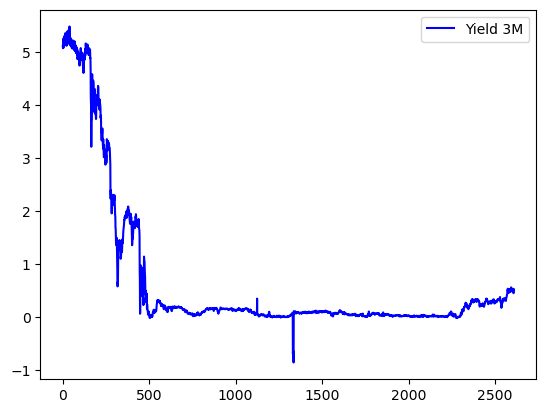

In [3]:
#Plot the time series of 3m yield 
%matplotlib inline
plt.plot(dataset['003M'].values, color = 'blue')
plt.legend((['Yield 3M'])) 

In [4]:
#We have the following termstructure (month)
tenorstructure = [1,2,3,6,9,12,18,24,36,48,60,84,120,180,240,300,360]
len(tenorstructure)

17

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

x = tenorstructure

fig, (ax1) = plt.subplots(1,figsize=(12,6))

sinc, = ax1.plot(tenorstructure, dataset.iloc[0],  
                 linestyle = '-', marker ='o', color='blue', lw='3')

#legend = plt.legend()

def animate(i):
    x = tenorstructure
    f = dataset.iloc[i]
    sinc.set_ydata(f)
    sinc.set_label('Date =' + str(dataset.index[i]))
    legend = plt.legend(loc='upper right')
    #legend.remove()
    #legend = plt.legend()
    #plt.set_label()
    
def init():
    ax1.set_xlim(-2.0,365.0)
    ax1.set_ylim(0.0,6.0)
    ax1.axhline(0, color = 'black', lw=1)
    plt.rcParams.update({'font.size':14})
    plt.grid()
    plt.xlabel('Tenor (month)')
    plt.ylabel('Yield (%)')
    plt.title('USD yield curve from 01.01.2007 to 30.12.2016')
    #plt.legend(loc = 'lower right', frameon = True)
    
    return sinc,

step = 1
steps = np.arange(0,len(dataset)-1,step)
ani = FuncAnimation(fig, animate, steps, init_func = init, interval = 200, blit = True)

<IPython.core.display.Javascript object>

<Axes: xlabel='Date'>

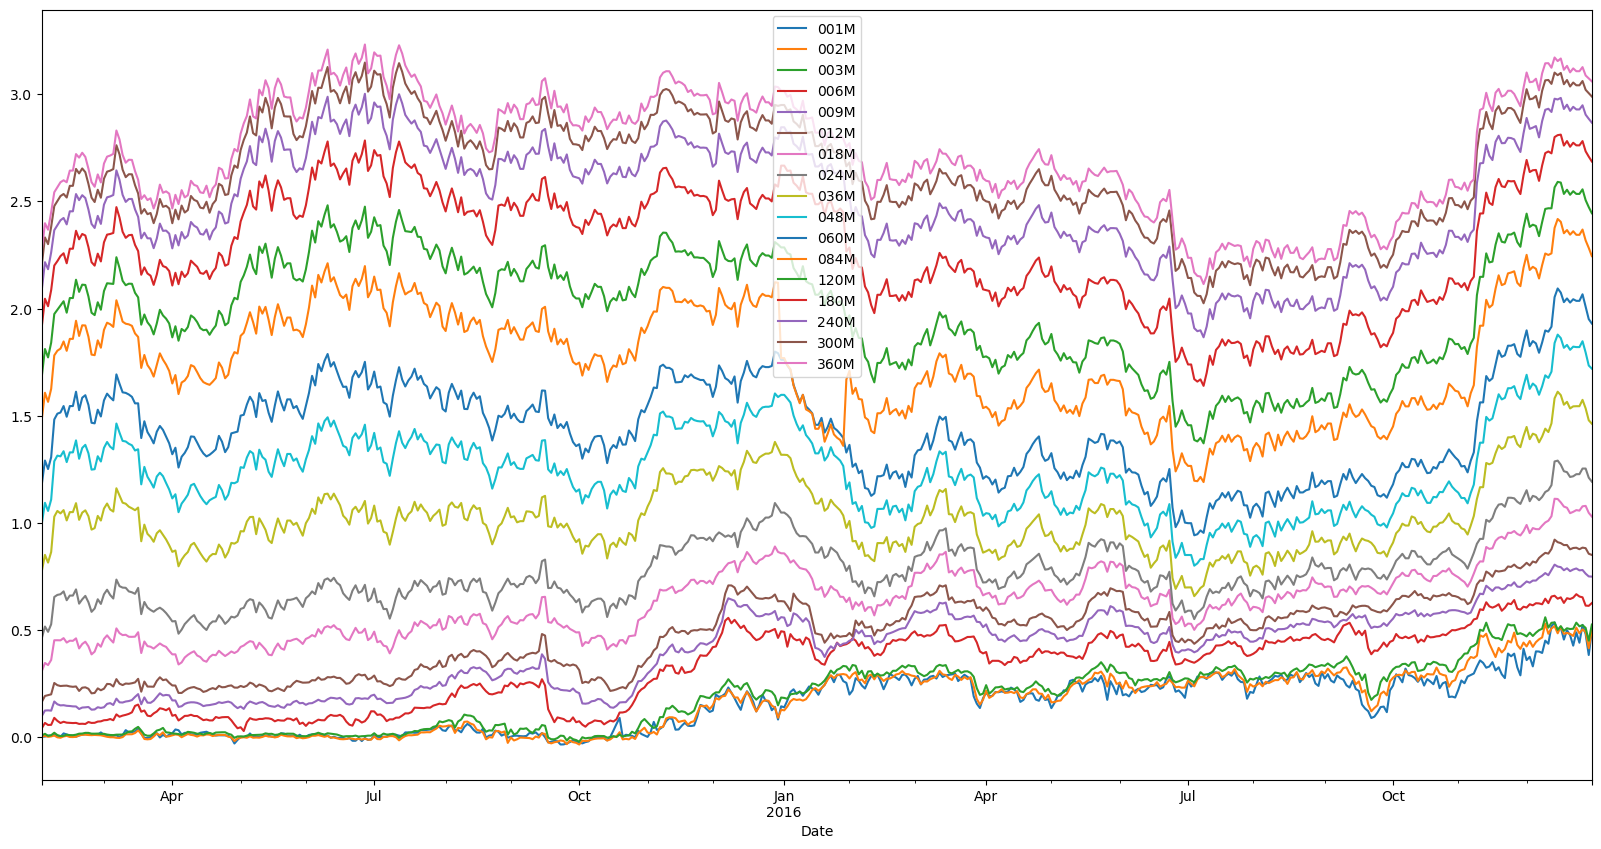

In [6]:
#Let us plot time series of several tenors
%matplotlib inline
dataset[-500:].plot(figsize=(20,10))

Assume we are trading the bonds and we have explosure to many of them. We want to calculate our risks and PnL. One way to do that is to calculate the moves of each tenor. However, due to large amount of tenors and curves this will be computationally expensive and risk structure becomes complex. For this reason we introduce PCA to this problem and will try to represent the whole curve movement by movement of principal components.

In [7]:
# First let us take a look at the cross-tenor correlation matrix 
np.round(dataset.diff().dropna().corr(),2)

,001M,002M,003M,006M,009M,012M,018M,024M,036M,048M,060M,084M,120M,180M,240M,300M,360M
001M,1.00,0.61,0.59,0.56,0.49,0.42,0.31,0.29,0.23,0.20,0.19,0.15,0.14,0.12,0.11,0.11,0.11
002M,0.61,1.00,0.84,0.63,0.47,0.44,0.35,0.32,0.28,0.26,0.22,0.17,0.16,0.14,0.13,0.12,0.12
003M,0.59,0.84,1.00,0.70,0.52,0.51,0.41,0.37,0.32,0.29,0.25,0.20,0.18,0.16,0.15,0.15,0.15
006M,0.56,0.63,0.70,1.00,0.90,0.79,0.64,0.56,0.49,0.45,0.41,0.34,0.31,0.28,0.26,0.25,0.25
009M,0.49,0.47,0.52,0.90,1.00,0.92,0.77,0.67,0.60,0.55,0.51,0.43,0.40,0.35,0.34,0.32,0.32
012M,0.42,0.44,0.51,0.79,0.92,1.00,0.90,0.81,0.74,0.68,0.64,0.55,0.50,0.45,0.43,0.41,0.40
018M,0.31,0.35,0.41,0.64,0.77,0.90,1.00,0.97,0.92,0.86,0.81,0.71,0.66,0.59,0.56,0.54,0.52
024M,0.29,0.32,0.37,0.56,0.67,0.81,0.97,1.00,0.96,0.92,0.87,0.78,0.73,0.66,0.62,0.60,0.58
036M,0.23,0.28,0.32,0.49,0.60,0.74,0.92,0.96,1.00,0.97,0.94,0.86,0.82,0.76,0.72,0.70,0.68
048M,0.20,0.26,0.29,0.45,0.55,0.68,0.86,0.92,0.97,1.00,0.99,0.90,0.88,0.83,0.79,0.77,0.75


# How the correlation changes with change in tenor?

In [8]:
#PCA
dataset_change = dataset.diff().dropna()
X = np.matrix(dataset_change) #Dataset in the matrix form
X_dm = X - np.mean(X,axis =0)#Normalise the data set to make it with zero mean acroos the tenors
Cov_X = np.cov(X_dm, rowvar = False)#Calculate the covariance matrix
eigen = np.linalg.eig(Cov_X) #Calculate the eigen values and eigen vectors
eig_values_X = np.matrix(eigen[0]) #Separate the eigen values
eig_vectors_X = np.matrix(eigen[1]) #Separate the eigen vectors
Y_dm = X_dm * eig_vectors_X #Calculate the principal components

In [9]:
yields_trans = Y_dm.copy()

In [10]:
eig_values_X #Let us take a look at eigen values

matrix([[3.42883339e-02, 1.39212159e-02, 3.97890658e-03, 2.94477147e-03,
         1.49174822e-03, 7.76688711e-04, 5.02059279e-04, 3.17789952e-04,
         1.79013299e-04, 1.24097576e-04, 6.56566303e-05, 5.07683339e-05,
         1.20039518e-05, 2.60315559e-06, 6.25289946e-07, 1.37767194e-07,
         9.42726275e-08]])

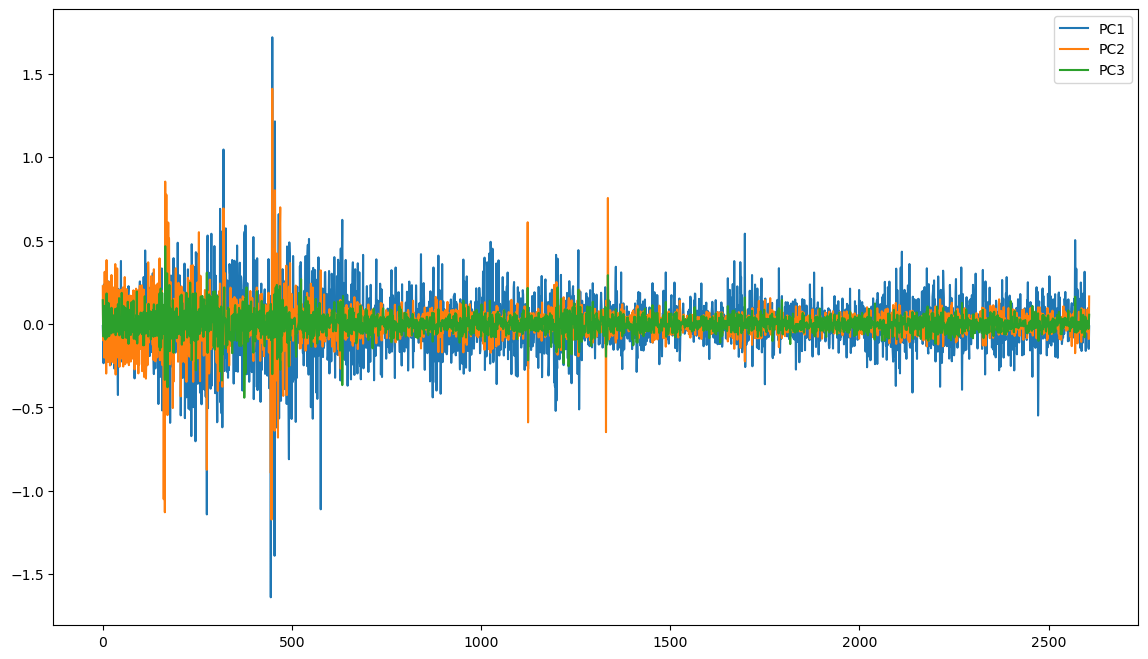

In [11]:
#Plotting the furst three principal components
plt.figure(figsize =(14,8))
plt.plot(yields_trans[:,0:3])
plt.legend(['PC1','PC2','PC3'])

In [12]:
#Let us now understand what the first principal components mean: calculate their correlations with 
pc_yields = dataset_change.copy()
pc_yields['Yield_PC1'] = yields_trans[:,0]
pc_yields['Yield_PC2'] = yields_trans[:,1]
pc_yields['Yield_PC3'] = yields_trans[:,2]

#Correlation
np.round(pc_yields.corr(),2)

,001M,002M,003M,006M,009M,012M,018M,024M,036M,048M,060M,084M,120M,180M,240M,300M,360M,Yield_PC1,Yield_PC2,Yield_PC3
001M,1.00,0.61,0.59,0.56,0.49,0.42,0.31,0.29,0.23,0.20,0.19,0.15,0.14,0.12,0.11,0.11,0.11,0.36,0.75,0.24
002M,0.61,1.00,0.84,0.63,0.47,0.44,0.35,0.32,0.28,0.26,0.22,0.17,0.16,0.14,0.13,0.12,0.12,0.40,0.80,0.15
003M,0.59,0.84,1.00,0.70,0.52,0.51,0.41,0.37,0.32,0.29,0.25,0.20,0.18,0.16,0.15,0.15,0.15,0.43,0.77,0.08
006M,0.56,0.63,0.70,1.00,0.90,0.79,0.64,0.56,0.49,0.45,0.41,0.34,0.31,0.28,0.26,0.25,0.25,0.56,0.61,-0.23
009M,0.49,0.47,0.52,0.90,1.00,0.92,0.77,0.67,0.60,0.55,0.51,0.43,0.40,0.35,0.34,0.32,0.32,0.63,0.44,-0.38
012M,0.42,0.44,0.51,0.79,0.92,1.00,0.90,0.81,0.74,0.68,0.64,0.55,0.50,0.45,0.43,0.41,0.40,0.72,0.33,-0.45
018M,0.31,0.35,0.41,0.64,0.77,0.90,1.00,0.97,0.92,0.86,0.81,0.71,0.66,0.59,0.56,0.54,0.52,0.84,0.14,-0.48
024M,0.29,0.32,0.37,0.56,0.67,0.81,0.97,1.00,0.96,0.92,0.87,0.78,0.73,0.66,0.62,0.60,0.58,0.87,0.05,-0.42
036M,0.23,0.28,0.32,0.49,0.60,0.74,0.92,0.96,1.00,0.97,0.94,0.86,0.82,0.76,0.72,0.70,0.68,0.92,-0.06,-0.32
048M,0.20,0.26,0.29,0.45,0.55,0.68,0.86,0.92,0.97,1.00,0.99,0.90,0.88,0.83,0.79,0.77,0.75,0.94,-0.13,-0.22


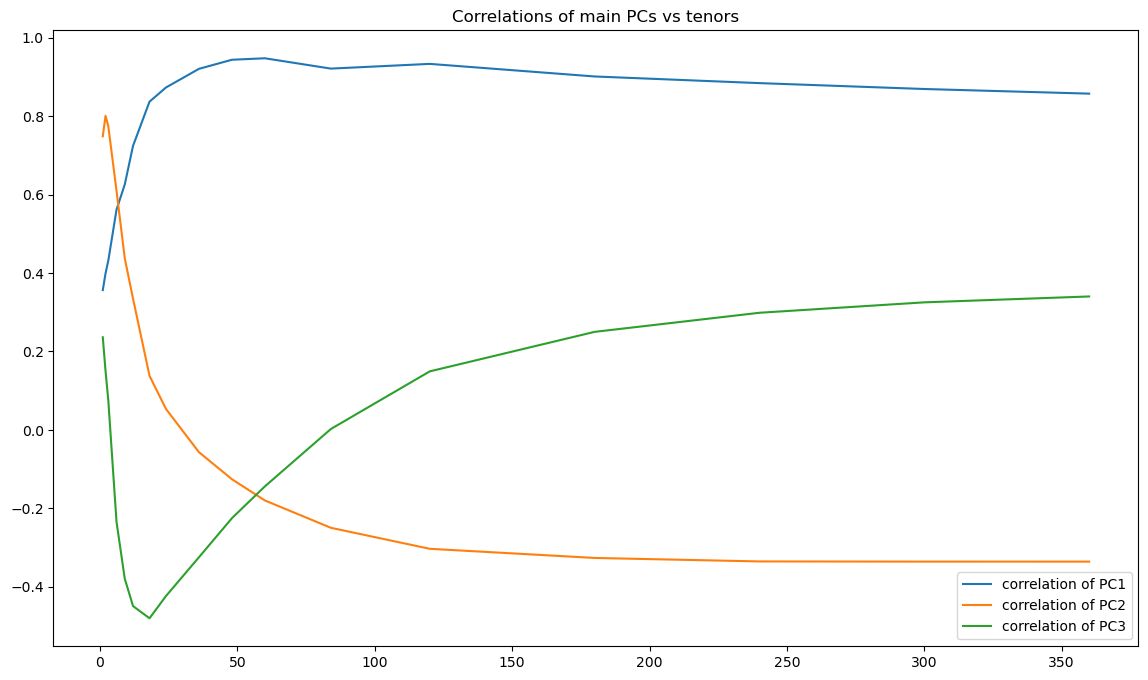

In [13]:
plt.figure(figsize =(14,8))
plt.plot(tenorstructure, pc_yields.corr()['Yield_PC1'][:17])
plt.plot(tenorstructure, pc_yields.corr()['Yield_PC2'][:17])
plt.plot(tenorstructure, pc_yields.corr()['Yield_PC3'][:17])
plt.title('Correlations of main PCs vs tenors')
plt.legend(['correlation of PC1','correlation of PC2','correlation of PC3'])

In [14]:
#Let us understand how much movement in the curve we can explain by these the first three main components
var_explained =np.zeros(eig_values_X.shape[1])
var_explained_agg =np.zeros(eig_values_X.shape[1])

eig_values_X_mat = np.diagflat(np.array(eig_values_X))
eigen_values = eig_values_X_mat.diagonal() ##diagonal matrix of eigen values
eig_values_sum_all = np.sum(eigen_values) #all variance

for i in range(len(eigen_values)): 
    var_explained[i] = eigen_values[i] / eig_values_sum_all #calculate how much we can explain by individual PCs
    
    
    eig_val_sum = np.sum(eigen_values[0:i+1]) #calculate how much we can explain cumulatively
    var_explained_agg[i] = eig_val_sum / eig_values_sum_all 
    

print('')
print('\t \t \t PC1    PC2   PC3   PC4   PC5')
print('')
print('Variance explained:     ', np.round(var_explained[0:5],3))
print('Agg Variance explained: ', np.round(var_explained_agg[0:5],3))
print('')


	 	 	 PC1    PC2   PC3   PC4   PC5

Variance explained:      [0.585 0.237 0.068 0.05  0.025]
Agg Variance explained:  [0.585 0.822 0.89  0.94  0.965]



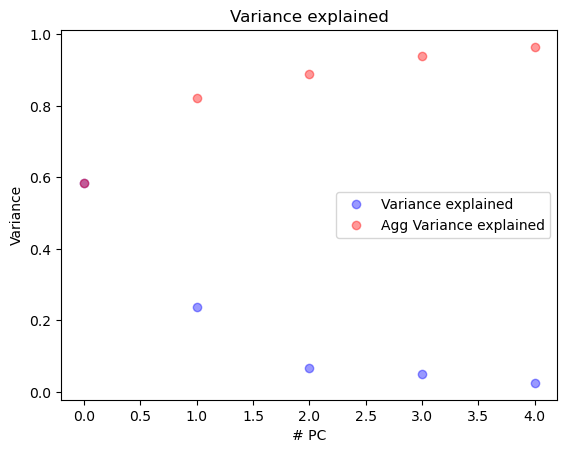

In [15]:
plt.plot(np.round(var_explained[0:5],3),'o',c='blue', alpha=0.4, label ='Variance explained')
plt.plot(np.round(var_explained_agg[0:5],3),'o',c='red', alpha=0.4, label = 'Agg Variance explained')
plt.title('Variance explained')
plt.xlabel('# PC')
plt.ylabel('Variance')
plt.legend()
plt.show()

## Consider demo case with only two tenors: 1M and 12M

In [16]:
dataset.head()

,001M,002M,003M,006M,009M,012M,018M,024M,036M,048M,060M,084M,120M,180M,240M,300M,360M
Date,,,,,,,,,,,,,,,,,
2007-01-01,5.149761,5.080501,5.116759,5.101547,5.118114,5.009010,4.880455,4.811575,4.727199,4.697020,4.689861,4.689468,4.705387,4.739908,4.774431,4.797631,4.809736
2007-01-02,5.451227,5.227717,5.087355,5.050118,5.068344,4.968771,4.856429,4.806342,4.705050,4.676302,4.669601,4.669657,4.682148,4.715702,4.749765,4.773601,4.785332
2007-01-03,5.283516,5.138073,5.088074,5.092884,5.077623,4.965366,4.855207,4.767058,4.672516,4.652265,4.648387,4.652097,4.660393,4.694007,4.727878,4.752009,4.763874
2007-01-04,5.107468,5.041965,5.077561,5.053720,5.054209,4.952816,4.787750,4.693781,4.607565,4.589840,4.587861,4.592507,4.604393,4.638833,4.672702,4.696493,4.708451
2007-01-05,5.232914,5.176262,5.260682,5.157881,5.135440,4.986602,4.829259,4.750288,4.659182,4.643782,4.635823,4.634441,4.646899,4.677596,4.706772,4.728169,4.738921


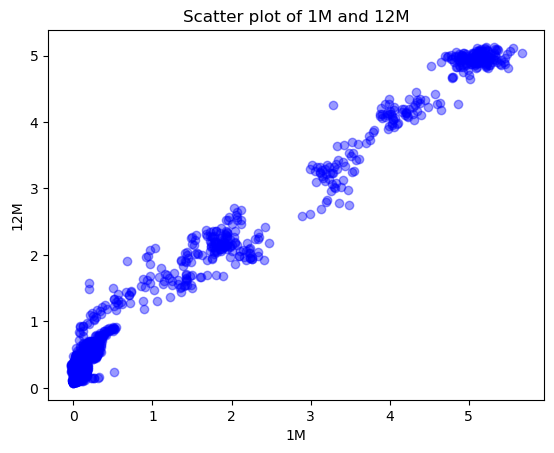

In [17]:
plt.scatter(dataset['001M'], dataset['012M'] ,c='blue', alpha=0.4)
plt.title('Scatter plot of 1M and 12M')
plt.xlabel('1M')
plt.ylabel('12M')
plt.show()

In [18]:
X = np.matrix(pd.concat([dataset['001M'], dataset['012M']], axis=1)) #Dataset in the matrix form
X_dm = X - np.mean(X,axis =0)#Normalise the data set to make it with zero mean acroos the tenors
Cov_X = np.cov(X_dm, rowvar = False)#Calculate the covariance matrix
eigen = np.linalg.eig(Cov_X) #Calculate the eigen values and eigen vectors
eig_values_X = np.matrix(eigen[0]) #Separate the eigen values
eig_vectors_X = np.matrix(eigen[1]) #Separate the eigen vectors
Y_dm = X_dm * eig_vectors_X #Calculate the principal components

In [19]:
eigen

(array([3.79629865, 0.01673228]),
 array([[ 0.72626759, -0.68741209],
        [ 0.68741209,  0.72626759]]))

In [20]:
np.array(eig_vectors_X[:,0])*np.array(eig_vectors_X[:,1])

array([[-0.49924513],
       [ 0.49924513]])

In [21]:
np.array(X_dm[:,0])

array([[ 4.46807222],
       [ 4.76953832],
       [ 4.60182729],
       ...,
       [-0.19966364],
       [-0.29770902],
       [-0.18326863]])

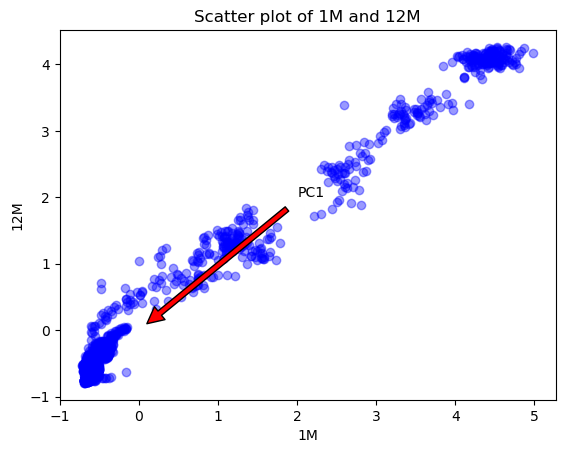

In [22]:
plt.scatter(np.array(X_dm[:,0]), np.array(X_dm[:,1]) ,c='blue', alpha=0.4)
plt.annotate('PC1', xy=(0.0, 0.0), xytext=(3*0.72626759,  3*0.68741209),
            arrowprops=dict(facecolor='red', shrink=0.05), ha='center', va='center')

#plt.annotate('PC2', xy=(0.0, 0.0), xytext=(-1*-0.68741209,  -1*0.72626759),
#            arrowprops=dict(facecolor='red', shrink=0.05), ha='center', va='center')
plt.title('Scatter plot of 1M and 12M')
plt.xlabel('1M')
plt.ylabel('12M')
plt.show()

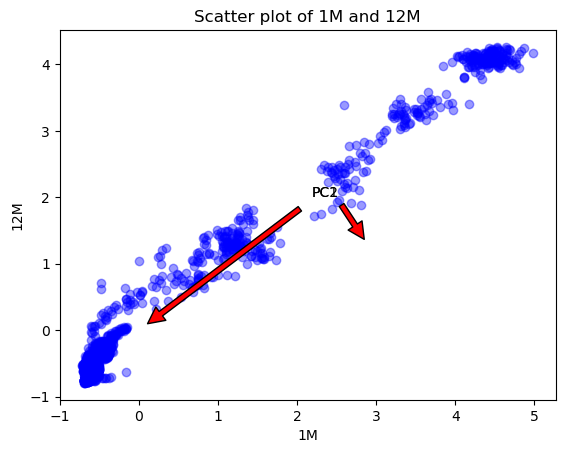

In [23]:
plt.scatter(np.array(X_dm[:,0]), np.array(X_dm[:,1]) ,c='blue', alpha=0.4)
plt.annotate('PC1', xy=(0.0, 0.0), xytext=(3*0.72626759,  3*0.68741209),
             arrowprops=dict(facecolor='red', shrink=0.05), ha='left', va='center')

plt.annotate('PC2', xy=(3*0.72626759 + -1*-0.68741209,  3*0.68741209 + -1*0.72626759), xytext=(3*0.72626759,  3*0.68741209),
                        arrowprops=dict(facecolor='red', shrink=0.05), ha='left', va='center')
plt.title('Scatter plot of 1M and 12M')
plt.xlabel('1M')
plt.ylabel('12M')
plt.show()